In [6]:
using JuMP, Cbc, PyPlot

function solveBTB(n_workers, quotas, task_bundle_times)
    n_tasks = size(task_bundle_times,1)
    m = Model(solver=CbcSolver())
    @variable(m, work[1:n_workers, 1:n_tasks, 1:horizon], Bin)
    @variable(m, slowest_worker >= 0)

    @expression(m, work_on[j in 1:n_tasks], sum(work[i,j,t]*t for t in 1:horizon, i in 1:n_workers))

    # we must meet quotas
    @constraint(m, quota_constr[j in 1:n_tasks], work_on[j] >= quotas[j])

    # worker speed
    @expression(m, worker_speed[i in 1:n_workers],
        sum(sum(task_bundle_times[j, t] * work[i,j,t] for t in 1:horizon) for j in 1:n_tasks))

    # Each worker works on either 1 task, 2 tasks, 3 etc.
    for i in 1:n_workers, j in 1:n_tasks
        addSOS1(m, work[i,j,:])
    end

    # epigraph bound for slowest_worker
    @constraint(m, worker_speed .<= slowest_worker)

    # minimize the amount of time the slowest worker takes
    @objective(m, Min, slowest_worker)

    solve(m)
    
    getvalue(work), getobjectivevalue(m)
end

function completion_speeds(initial_length, min_length, learning_speed, horizon)
    n_tasks = size(min_length, 1)
    [(max.(min_length[j], initial_length[j]-T*learning_speed[j]))
        for j in 1:n_tasks, T in 0:horizon-1]
end

completion_speeds (generic function with 1 method)

In [7]:
function plot_sched(α, speeds)
    horizon = size(α,3)
    n_tasks = size(α,2)
    n_workers = size(α,1)
    L = round.(Int, sum(α[:,:,i]*i for i=1:horizon))
    task_dur = zeros(n_workers, n_tasks)

    for i=1:n_workers
        for j=1:n_tasks
            for k=1:L[i, j]
                task_dur[i, j] = task_dur[i, j] + speeds[j, k]
            end
        end
    end

    ind = 1:n_workers
    width = 0.35

    fig = figure(figsize=[9, 9])

    colors = rand(n_tasks)
    lft = zeros(n_workers)

    for j=1:size(task_dur)[2]
        barh(ind, task_dur[:, j], left=lft, color=rand(3), label="Task Type $j")
        #barh(ind, task_dur[:, j], left=lft, label="Task Type $j")
        lft = lft + task_dur[:, j]
    end

    ylabel("Worker")
    xlabel("Time Units")
    title("Duration of Time that Workers Spend on Different Tasks")
    legend(loc="center left", bbox_to_anchor=(1, 0.5))
    
    show()
end

plot_sched (generic function with 1 method)

# 1. All workers have similar initial ability

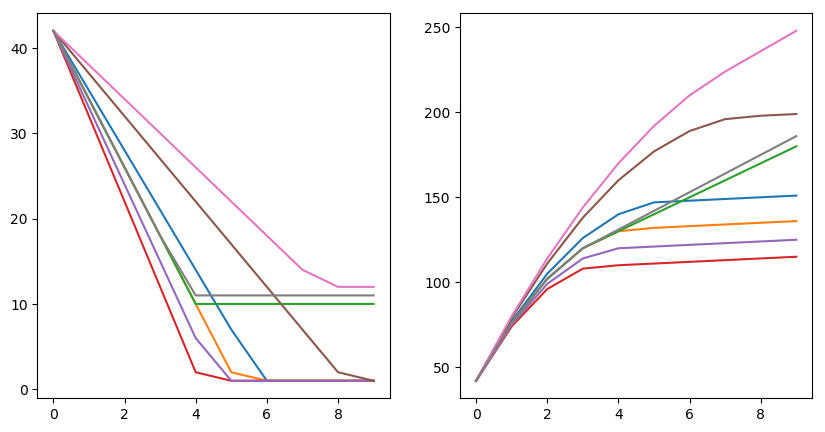

In [14]:
function similar_initial(n_workers, n_tasks)
    quotas = rand(5:10,1,n_tasks)
    horizon = maximum(quotas)
    initial_task_length = ones(n_tasks) * rand(30:50)
    min_task_length = max.(1, initial_task_length - rand(30:50, n_tasks))
    learning_speed = rand(4:10, n_tasks)

    speeds = completion_speeds(initial_task_length, min_task_length, learning_speed, horizon)
    bundle_times = cumsum(speeds,2)

    speeds, bundle_times
end

n_workers = 5
n_tasks = 8
speeds, bundle_times = similar_initial(n_workers, n_tasks)

figure(figsize=(10, 5))
subplot(121); plot(speeds')
subplot(122); plot(bundle_times')
show()

# 2. All workers skilled at one task

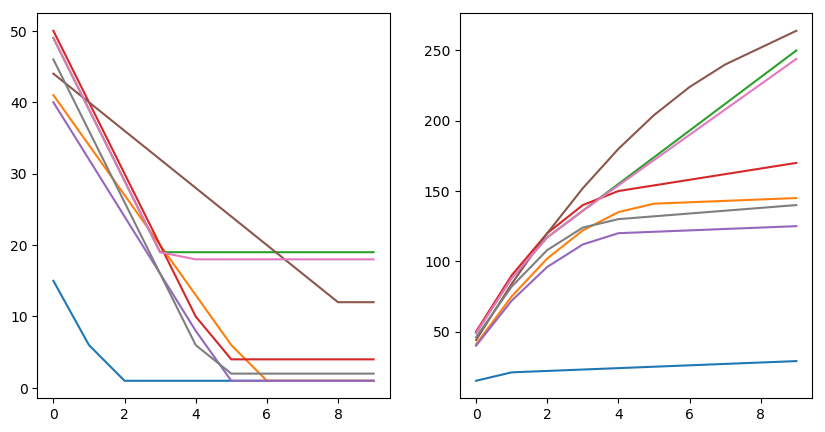

In [27]:
function skilled_at_one(n_workers, n_tasks; α=.3)
    quotas = rand(5:10,1,n_tasks)
    horizon = maximum(quotas)
    initial_task_length = rand(40:50, n_tasks)
    initial_task_length[1] = round(α * initial_task_length[1])
    min_task_length = max.(1, initial_task_length - rand(30:50, n_tasks))
    learning_speed = rand(4:10, n_tasks)

    speeds = completion_speeds(initial_task_length, min_task_length, learning_speed, horizon)
    bundle_times = cumsum(speeds,2)

    speeds, bundle_times
end

n_workers = 5
n_tasks = 8
speeds, bundle_times = skilled_at_one(n_workers, n_tasks, α=.3)
figure(figsize=(10, 5))
subplot(121); plot(speeds')
subplot(122); plot(bundle_times')
show()

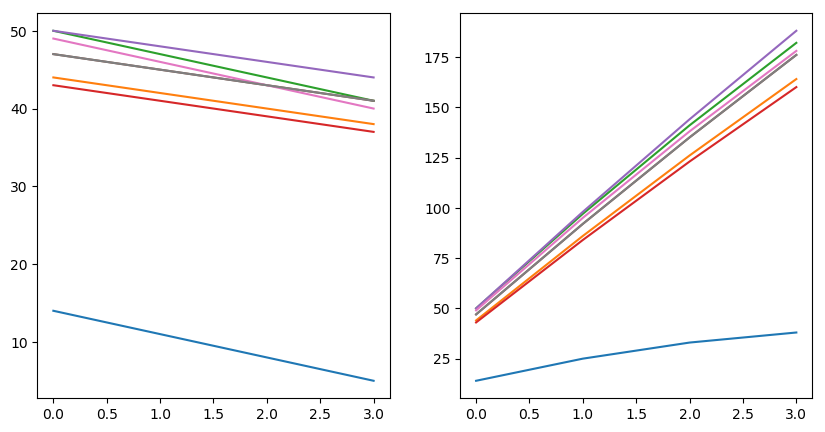

In [29]:
function short_quota(n_workers, n_tasks; α=.3)
    quotas = rand(3:4,1,n_tasks)
    horizon = maximum(quotas)
    initial_task_length = rand(40:50, n_tasks)
    initial_task_length[1] = round(α * initial_task_length[1])
    min_task_length = max.(1, initial_task_length - rand(30:50, n_tasks))
    learning_speed = rand(2:3, n_tasks)

    speeds = completion_speeds(initial_task_length, min_task_length, learning_speed, horizon)
    bundle_times = cumsum(speeds,2)

    speeds, bundle_times
end

n_workers = 5
n_tasks = 8
speeds, bundle_times = short_quota(n_workers, n_tasks, α=.3)
figure(figsize=(10, 5))
subplot(121); plot(speeds')
subplot(122); plot(bundle_times')
show()